In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense

In [0]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test  = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# Print info
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [0]:
# Define CAE model
in_layer = Input(shape=(28, 28, 1), name='IN')

x = Conv2D(256, (3, 3), activation='relu', padding='same')(in_layer)
x = MaxPooling2D()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

latent = MaxPooling2D(name='LATENT')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(latent)
x = UpSampling2D((4, 4))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D()(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = UpSampling2D()(x)

out_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='OUT')(x)

CAE = Model(in_layer, out_layer)
CAE.summary()

CAE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN (InputLayer)              [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0     

In [0]:
# Train model
history = CAE.fit(x_train, x_train, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 21s 55ms/step - loss: 0.2054 - accuracy: 0.7974 - val_loss: 0.1506 - val_accuracy: 0.8036
Epoch 2/100
375/375 [==============================] - 20s 53ms/step - loss: 0.1368 - accuracy: 0.8055 - val_loss: 0.1270 - val_accuracy: 0.8081
Epoch 3/100
375/375 [==============================] - 20s 53ms/step - loss: 0.1213 - accuracy: 0.8085 - val_loss: 0.1177 - val_accuracy: 0.8097
Epoch 4/100
375/375 [==============================] - 20s 53ms/step - loss: 0.1138 - accuracy: 0.8099 - val_loss: 0.1122 - val_accuracy: 0.8108
Epoch 5/100
375/375 [==============================] - 20s 53ms/step - loss: 0.1091 - accuracy: 0.8107 - val_loss: 0.1087 - val_accuracy: 0.8119
Epoch 6/100
375/375 [==============================] - 20s 53ms/step - loss: 0.1055 - accuracy: 0.8113 - val_loss: 0.1066 - val_accuracy: 0.8123
Epoch 7/100
375/375 [==============================] - 20s 53ms/step - loss: 0.1030 - accuracy: 0.8117 - val_loss: 0.1017 - val_ac

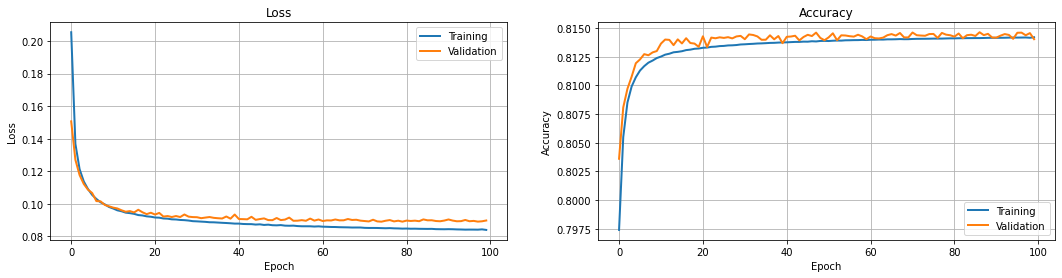

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(CAE.history.history['loss'], label='Training', linewidth=2)
plt.plot(CAE.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(CAE.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(CAE.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [0]:
# Predict reconstruction error on test data
test_loss = CAE.evaluate(x_test, x_test)
print(f"Test loss {test_loss[0]:.4f} -- Test accuracy {test_loss[1]:.4f}")

x_test_hat = CAE.predict(x_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0885 - accuracy: 0.8124
Test loss 0.0885 -- Test accuracy 0.8124


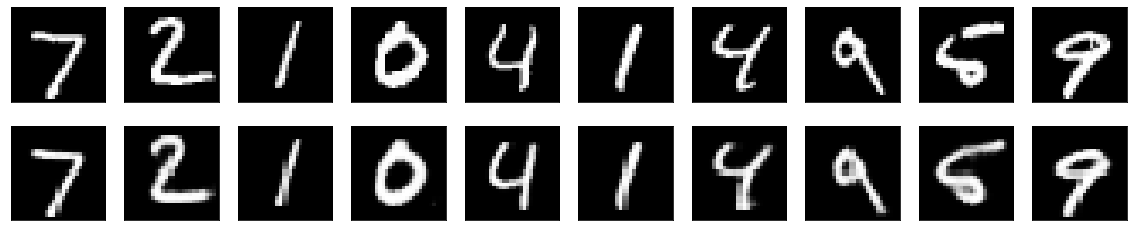

In [0]:
# Show a few reconstruction examples
plt.figure(figsize=(20, 4))
for i in range(10):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, 10, 10 + i + 1)
  plt.imshow(x_test_hat[i].reshape(28, 28), cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder = Model(inputs=in_layer, outputs=latent)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN (InputLayer)              [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0   

In [0]:
# Compute latent space
test_latent = encoder.predict(x_test).reshape((len(x_test), -1))
print(test_latent.shape)

(10000, 32)


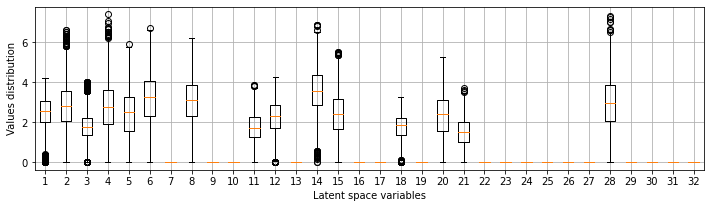

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(12, 3))
plt.boxplot(test_latent)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# Create a submodel using only the decoder part of the model
latent_input = Input(shape=(1, 1, 32))

deco = CAE.layers[-9](latent_input)
deco = CAE.layers[-8](deco)
deco = CAE.layers[-7](deco)
deco = CAE.layers[-6](deco)
deco = CAE.layers[-5](deco)
deco = CAE.layers[-4](deco)
deco = CAE.layers[-3](deco)
deco = CAE.layers[-2](deco)
deco = CAE.layers[-1](deco)

# create the decoder model
decoder_model = Model(inputs=latent_input, outputs=deco)
decoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 32)]        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 128)       0   

In [0]:
# Reconstruct from latent
test_hat = decoder_model.predict(test_latent.reshape((-1, 1, 1, 32)))
print(test_hat.shape)

(10000, 28, 28, 1)


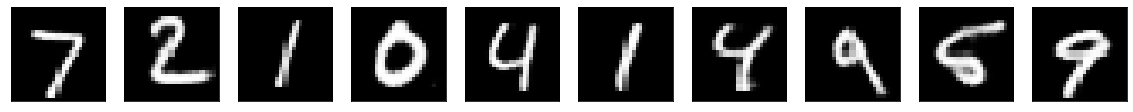

In [0]:
# Show a few reconstruction examples
plt.figure(figsize=(20, 3))
for i in range(10):
  ax = plt.subplot(1, 10, i + 1)
  plt.imshow(test_hat[i].reshape(28, 28), cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
# Encode training data
train_latent = encoder.predict(x_train).reshape((len(x_train), -1))

mean_train = train_latent.mean(axis=0)
std_train  = train_latent.std(axis=0)

In [0]:
# AUX function to sample from latent distribution
def sample_z():
  z = np.zeros((mean_train.shape))
  for ind in range(mean_train.shape[0]):
    z[ind] = np.random.normal(loc=mean_train[ind], scale=std_train[ind])
  return z

In [0]:
# Generate 10 random samples from latent distribution
z_samples_hat = np.zeros((10, 28, 28, 1))
for ind_samp in range(10):
  z_samples_hat[ind_samp] = decoder_model.predict(sample_z().reshape((-1, 1, 1, 32)))

print(z_samples_hat.shape)

(10, 28, 28, 1)


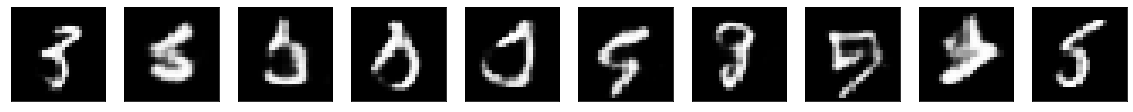

In [0]:
# Show a few reconstruction from random samples
plt.figure(figsize=(20, 3))
for i in range(10):
  ax = plt.subplot(1, 10, i + 1)
  plt.imshow(z_samples_hat[i].reshape(28, 28), cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()